## Charmonia Primordial Suppression in pPb Collision

### Importing & Loading & Setting Up

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys

sys.path.append("./cnm_combine")

from cnm_combine import (
    CNMCombine,
    DEFAULT_Y_EDGES,
    DEFAULT_P_EDGES,
    DEFAULT_Y_WINDOWS,
    DEFAULT_CENT_BINS,
    DEFAULT_PT_RANGE_AVG,
    cnm_vs_y_to_dataframe,
    cnm_vs_pT_to_dataframe,
    cnm_vs_cent_to_dataframe,
    combine_two_bands_1d,
)

In [7]:
## CNM
SAVE_PDF = True
SAVE_CSV = True
ALPHA_BAND = 0.22
DPI = 150

OUTDIR = Path("./output-cnm"); OUTDIR.mkdir(exist_ok=True)

CENT_BINS = DEFAULT_CENT_BINS       # e.g. [(0,20),(20,40),...]

ENERGY = "8.16"
FAMILY = "charmonia"
STATE  = "avg"   # CNM does not distinguish 1S/2S/1P here

comb = CNMCombine.from_defaults(
    energy=ENERGY,
    family=FAMILY,
    particle_state=STATE,
    cent_bins=CENT_BINS,
    y_edges=DEFAULT_Y_EDGES,
    p_edges=DEFAULT_P_EDGES,
    y_windows=DEFAULT_Y_WINDOWS,
    pt_range_avg=DEFAULT_PT_RANGE_AVG,
)


[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7757.76 mb, σ_tot^pA ≈ 1925.90 mb


## $R_{pA}$ vs Centrality

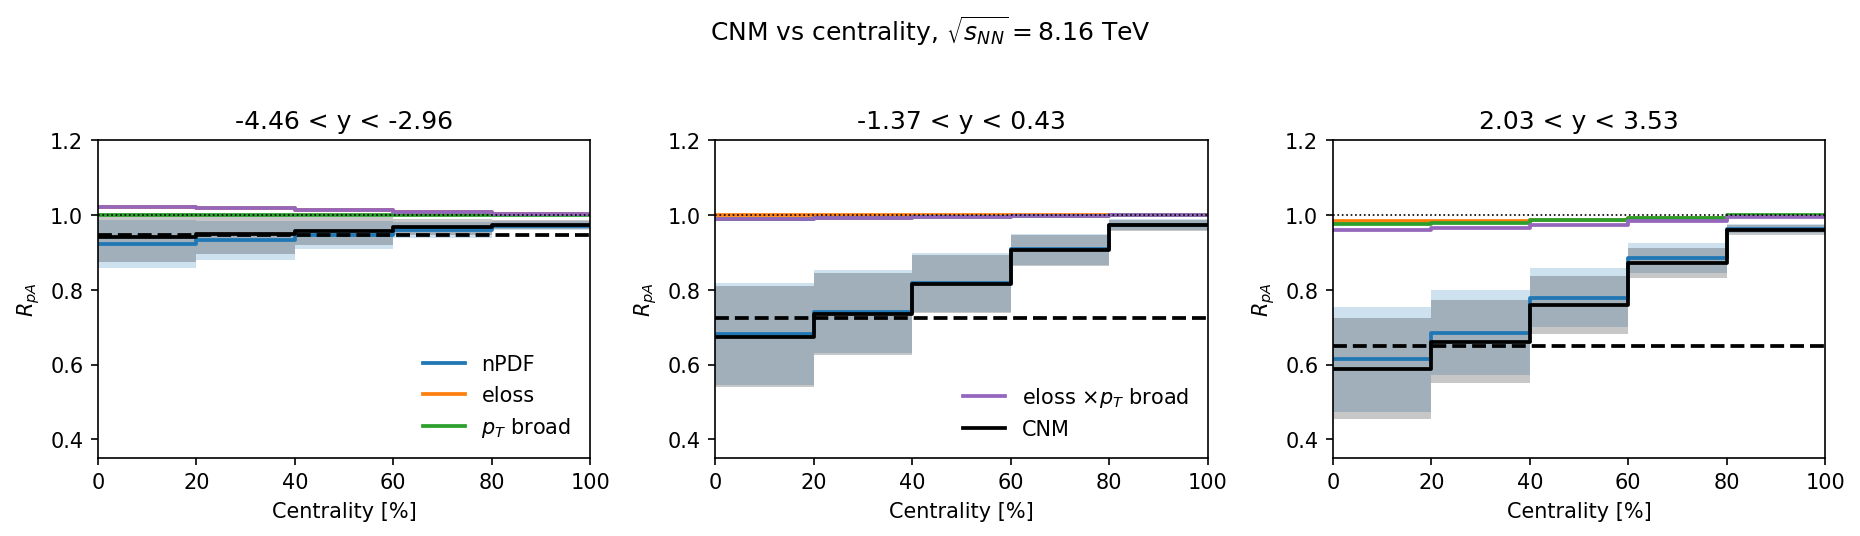

In [2]:

# ------------------------------------------------------------------
# 4. RpA vs centrality : compute + save CSV + plot
# ------------------------------------------------------------------

cnm_cent_all = {}

fig, axes = plt.subplots(1, 3, figsize=(12.5, 3.6), dpi=DPI, sharey=False)
axes = np.atleast_1d(axes).ravel()
handles_, labels_ = [], []

for ax, (y0, y1, name) in zip(axes, DEFAULT_Y_WINDOWS):
    cnm_cent = comb.cnm_vs_centrality(
        y_window=(y0, y1, name),
        pt_range_avg=DEFAULT_PT_RANGE_AVG,
        components=components,
    )
    cnm_cent_all[name] = cnm_cent

    # Save CSVs per component
    if SAVE_CSV:
        for comp in components:
            df_ce = cnm_vs_cent_to_dataframe(
                cent_bins=CENT_BINS,
                result=cnm_cent,
                component=comp,
            )
            safe_name = name.replace(" ", "").replace("<","").replace(">","").replace("y","y")
            df_ce.to_csv(
                OUTDIR / f"RpA_{comp}_vs_centrality_{safe_name}_{ENERGY.replace('.','p')}TeV.csv",
                index=False,
            )

    def cent_step_arrays(vals):
        vals = np.asarray(vals, float)
        edges = [CENT_BINS[0][0]] + [b for (_, b) in CENT_BINS]
        x_edges = np.array(edges, float)
        y_step = np.concatenate([vals, vals[-1:]])
        return x_edges, y_step

    for comp in components:
        Rc, Rlo, Rhi, Rc_MB, Rlo_MB, Rhi_MB = cnm_cent[comp]
        col = COMP_COLORS[comp]
        lab = COMP_LABELS[comp] if (ax is axes[0]) else None

        x_edges, y_c  = cent_step_arrays(Rc)
        _,       y_lo = cent_step_arrays(Rlo)
        _,       y_hi = cent_step_arrays(Rhi)

        ln, = ax.step(
            x_edges, y_c,
            where="post",
            lw=1.8,
            color=col, ls="-",
            label=lab,
        )
        ax.fill_between(
            x_edges, y_lo, y_hi,
            step="post",
            color=col, alpha=ALPHA_BAND, linewidth=0.0,
        )

        if comp == "cnm":
            x_mb = np.array([CENT_BINS[0][0], CENT_BINS[-1][1]], float)
            ax.hlines(Rc_MB, x_mb[0], x_mb[1],
                      colors="k", linestyles="--", linewidth=1.8)

        if lab is not None:
            handles_.append(ln)
            labels_.append(lab)

    ax.axhline(1.0, color="k", ls=":", lw=0.8)
    ax.set_xlabel("Centrality [%]")
    ax.set_ylabel(r"$R_{pA}$")
    ax.set_xlim(0, 100)
    ax.set_ylim(0.35, 1.20)
    ax.set_title(name)

# legends split between left & middle panels
uniq = {}
for h, l in zip(handles_, labels_):
    uniq[l] = h
legend_handles = list(uniq.values())
legend_labels  = list(uniq.keys())

if legend_handles:
    mid = (len(legend_handles) + 1) // 2
    handles_1 = legend_handles[:mid]
    labels_1  = legend_labels[:mid]
    handles_2 = legend_handles[mid:]
    labels_2  = legend_labels[mid:]

    axes[0].legend(handles_1, labels_1, loc="lower right", frameon=False)
    if handles_2:
        axes[1].legend(handles_2, labels_2, loc="lower right", frameon=False)

fig.suptitle(
    rf"CNM vs centrality, $\sqrt{{s_{{NN}}}}={comb.sqrt_sNN/1000:.2f}$ TeV"
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

if SAVE_PDF:
    fig.savefig(
        OUTDIR / f"RpA_CNM_vs_centrality_{ENERGY.replace('.','p')}TeV.pdf",
        bbox_inches="tight",
    )


## $R_{pA}$ vs Rapidity

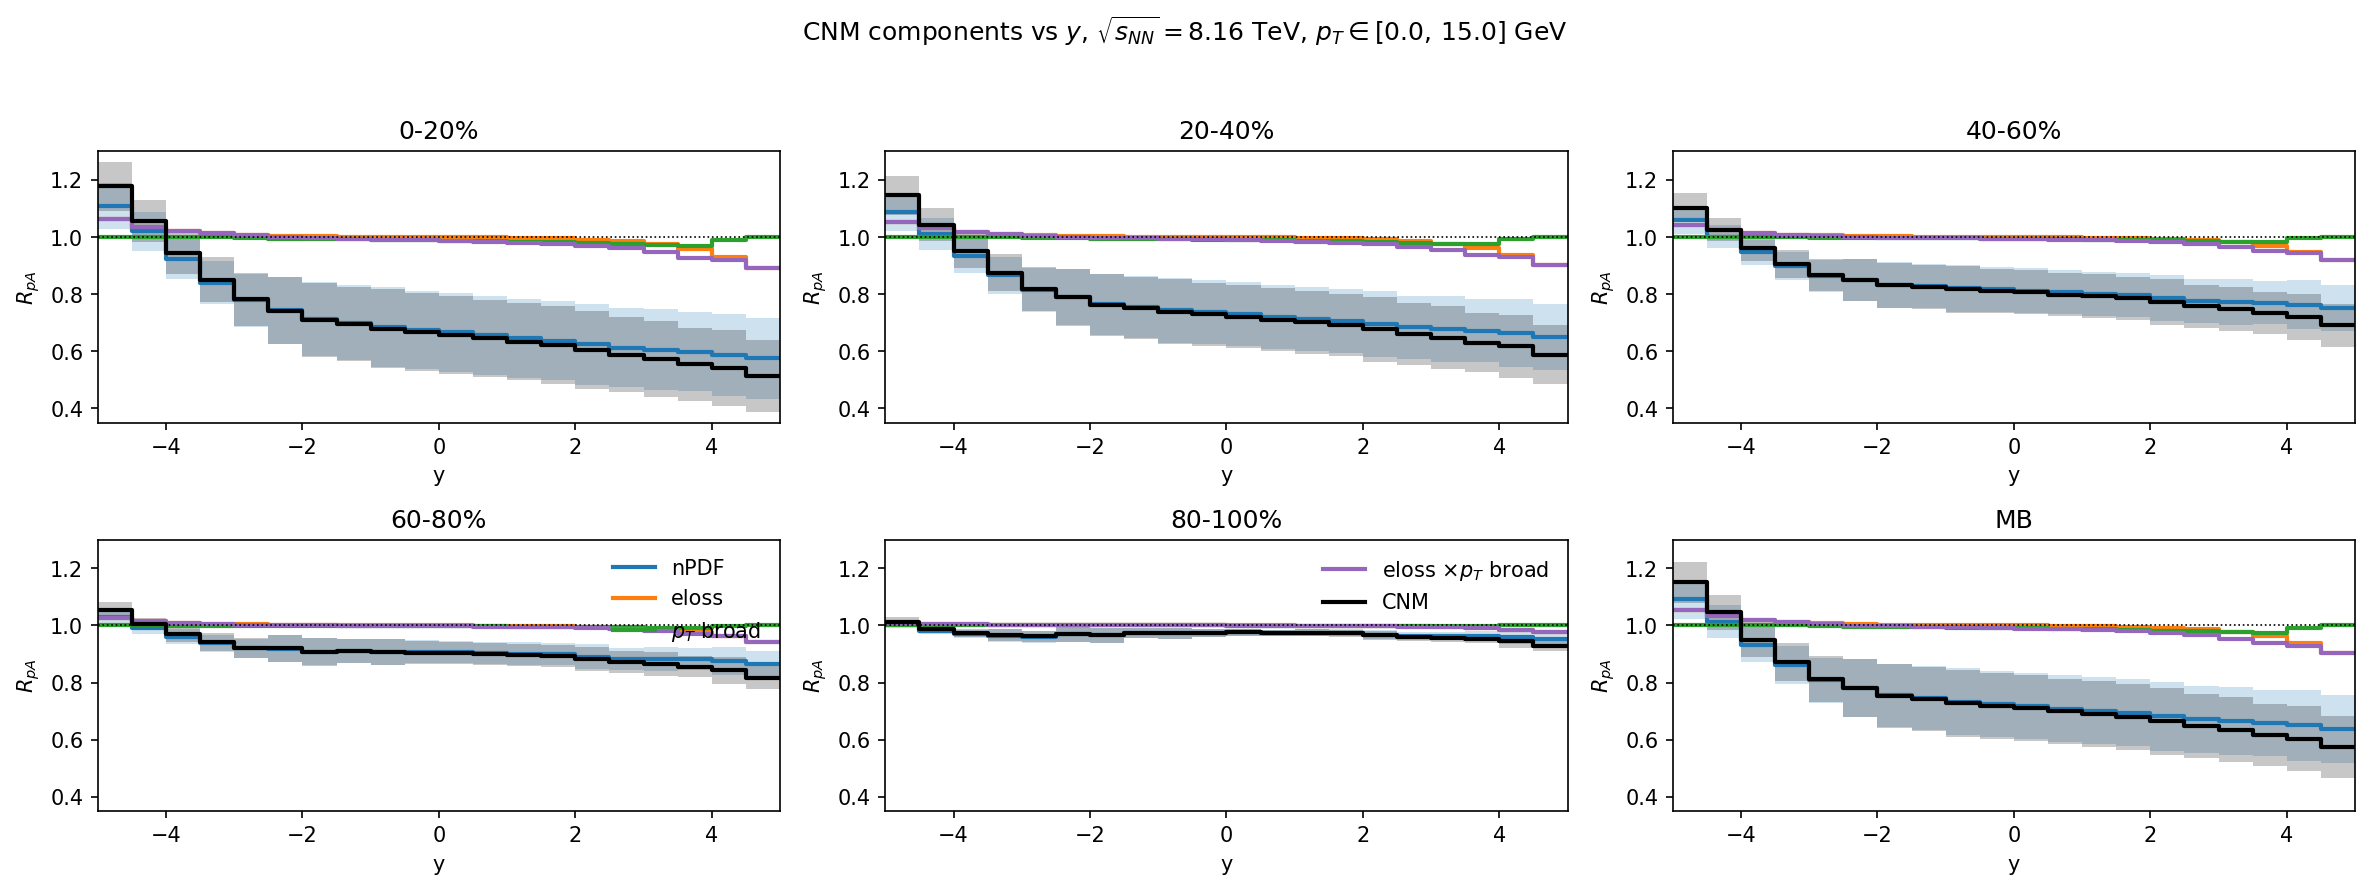

In [6]:

# ------------------------------------------------------------------
# 2. RpA vs y : compute + save CSV + plot
# ------------------------------------------------------------------

y_cent, tags_y, cnm_y = comb.cnm_vs_y(
    y_edges=DEFAULT_Y_EDGES,
    pt_range_avg=DEFAULT_PT_RANGE_AVG,
    include_mb=True,
    components=components,
)

# Save to CSV (one per component)
if SAVE_CSV:
    for comp in components:
        df_y = cnm_vs_y_to_dataframe(
            y_cent=y_cent,
            tags=tags_y,
            result=cnm_y,
            component=comp,
        )
        df_y.to_csv(
            OUTDIR / f"RpA_{comp}_vs_y_{ENERGY.replace('.','p')}TeV.csv",
            index=False,
        )

# Plot, following your original style (components stacked per panel)
n_pan = len(tags_y)
n_cols = 3
n_rows = int(np.ceil(n_pan / n_cols))

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5.3 * n_cols, 3.0 * n_rows),
    dpi=DPI,
    sharex=False,
    sharey=False,
)
axes = np.atleast_1d(axes).ravel()

handles_, labels_ = [], []

for ip, tag in enumerate(tags_y):
    ax = axes[ip]

    for comp in components:
        Rc, Rlo, Rhi = cnm_y[comp][tag]
        col = COMP_COLORS[comp]
        lab = COMP_LABELS[comp] if ip == 0 else None

        x_edges, y_c  = step_from_centers(y_cent, Rc)
        _,       y_lo = step_from_centers(y_cent, Rlo)
        _,       y_hi = step_from_centers(y_cent, Rhi)

        ln, = ax.step(
            x_edges, y_c,
            where="post",
            color=col, ls="-", lw=2.0,
            label=lab,
        )
        ax.fill_between(
            x_edges, y_lo, y_hi,
            step="post",
            color=col, alpha=ALPHA_BAND, linewidth=0.0,
        )

        if lab is not None:
            handles_.append(ln)
            labels_.append(lab)

    ax.axhline(1.0, color="k", ls=":", lw=0.8)
    ax.set_xlabel("y")
    ax.set_ylabel(r"$R_{pA}$")
    ax.set_title(tag)
    ax.set_ylim(0.35, 1.30)
    ax.set_xlim(-5, 5)
# clean up empty axes
for k in range(n_pan, len(axes)):
    fig.delaxes(axes[k])

# legend splitting if you want
uniq = {}
for h, l in zip(handles_, labels_):
    uniq[l] = h
legend_handles = list(uniq.values())
legend_labels  = list(uniq.keys())

if legend_handles:
    mid = (len(legend_handles) + 1) // 2
    handles_1 = legend_handles[:mid]
    labels_1  = legend_labels[:mid]
    handles_2 = legend_handles[mid:]
    labels_2  = legend_labels[mid:]

    if n_pan > 3:
        axes[3].legend(handles_1, labels_1, loc="upper right", frameon=False)
    if n_pan > 4 and handles_2:
        axes[4].legend(handles_2, labels_2, loc="upper right", frameon=False)

fig.suptitle(
    rf"CNM components vs $y$, $\sqrt{{s_{{NN}}}}={comb.sqrt_sNN/1000:.2f}$ TeV, "
    rf"$p_T\in[{DEFAULT_PT_RANGE_AVG[0]},\,{DEFAULT_PT_RANGE_AVG[1]}]$ GeV"
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

if SAVE_PDF:
    fig.savefig(
        OUTDIR / f"RpA_CNM_vs_y_{ENERGY.replace('.','p')}TeV.pdf",
        bbox_inches="tight",
    )

plt.show()

## $R_{pA}$ vs Transverse Momentum

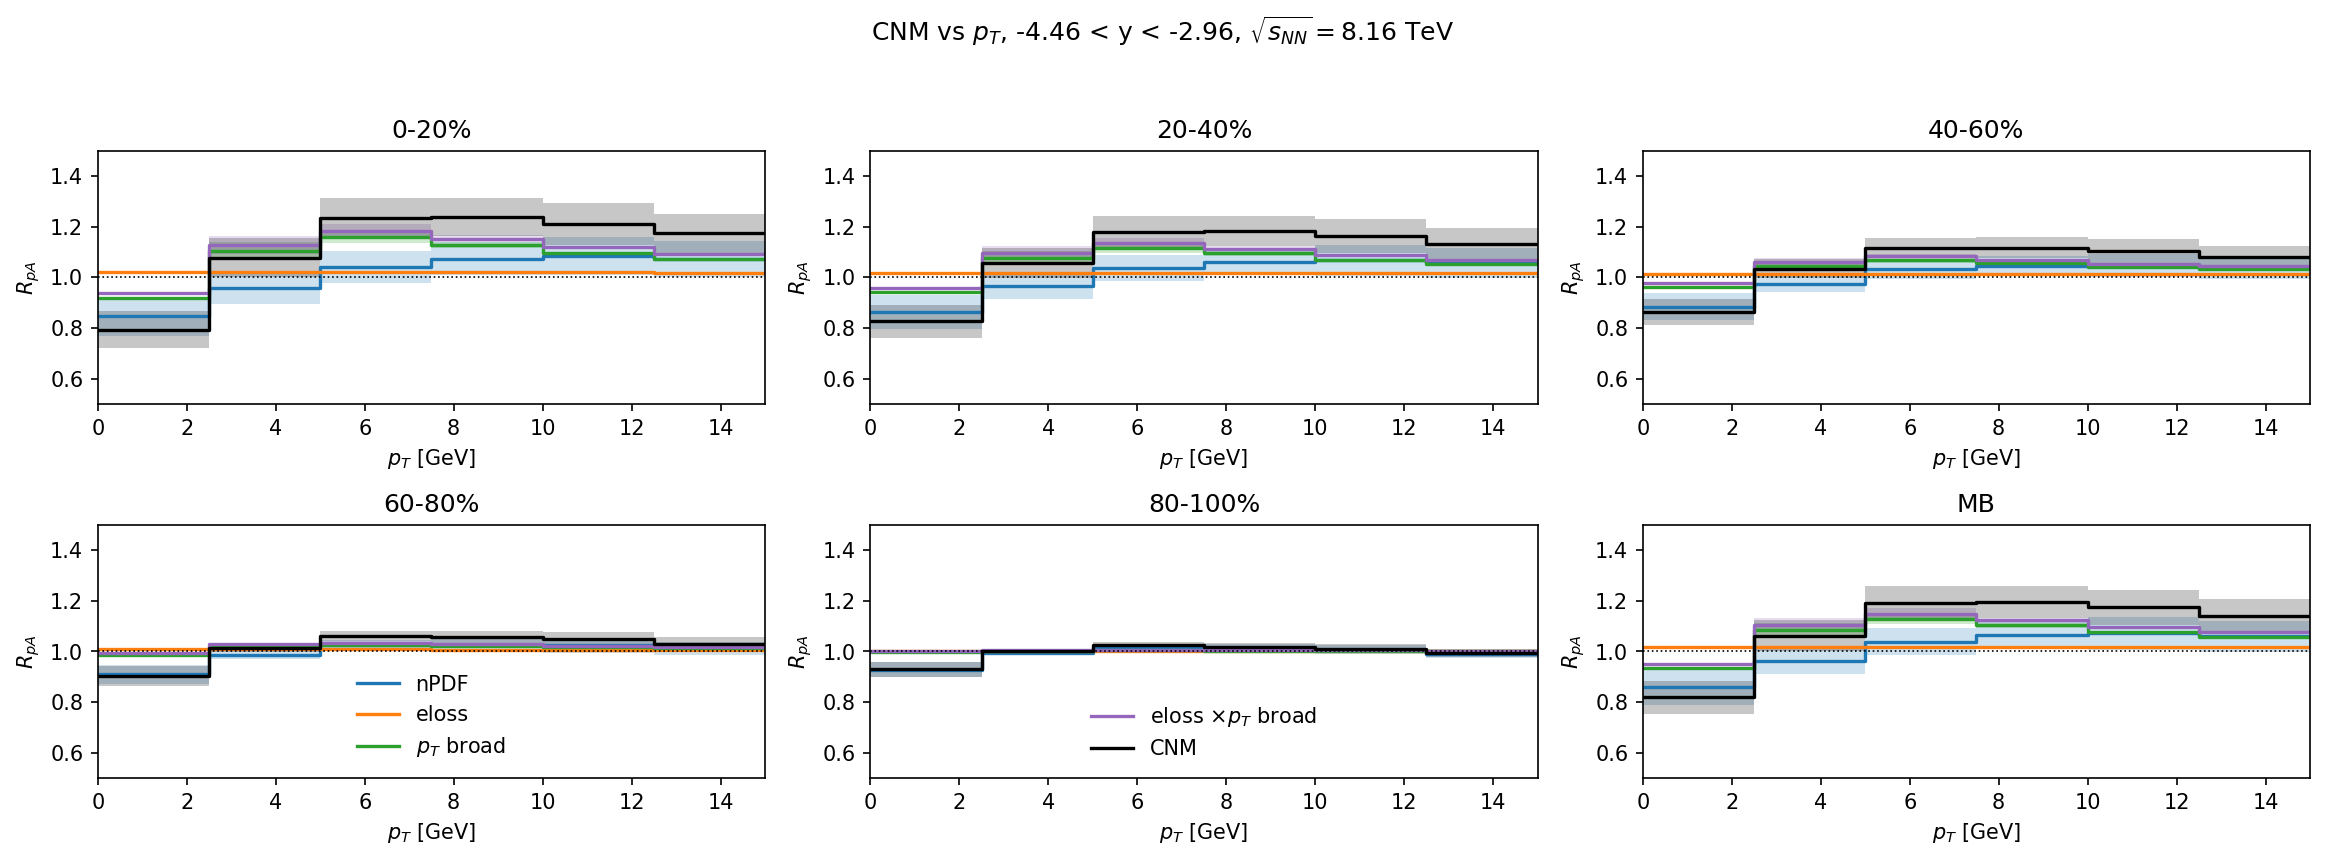

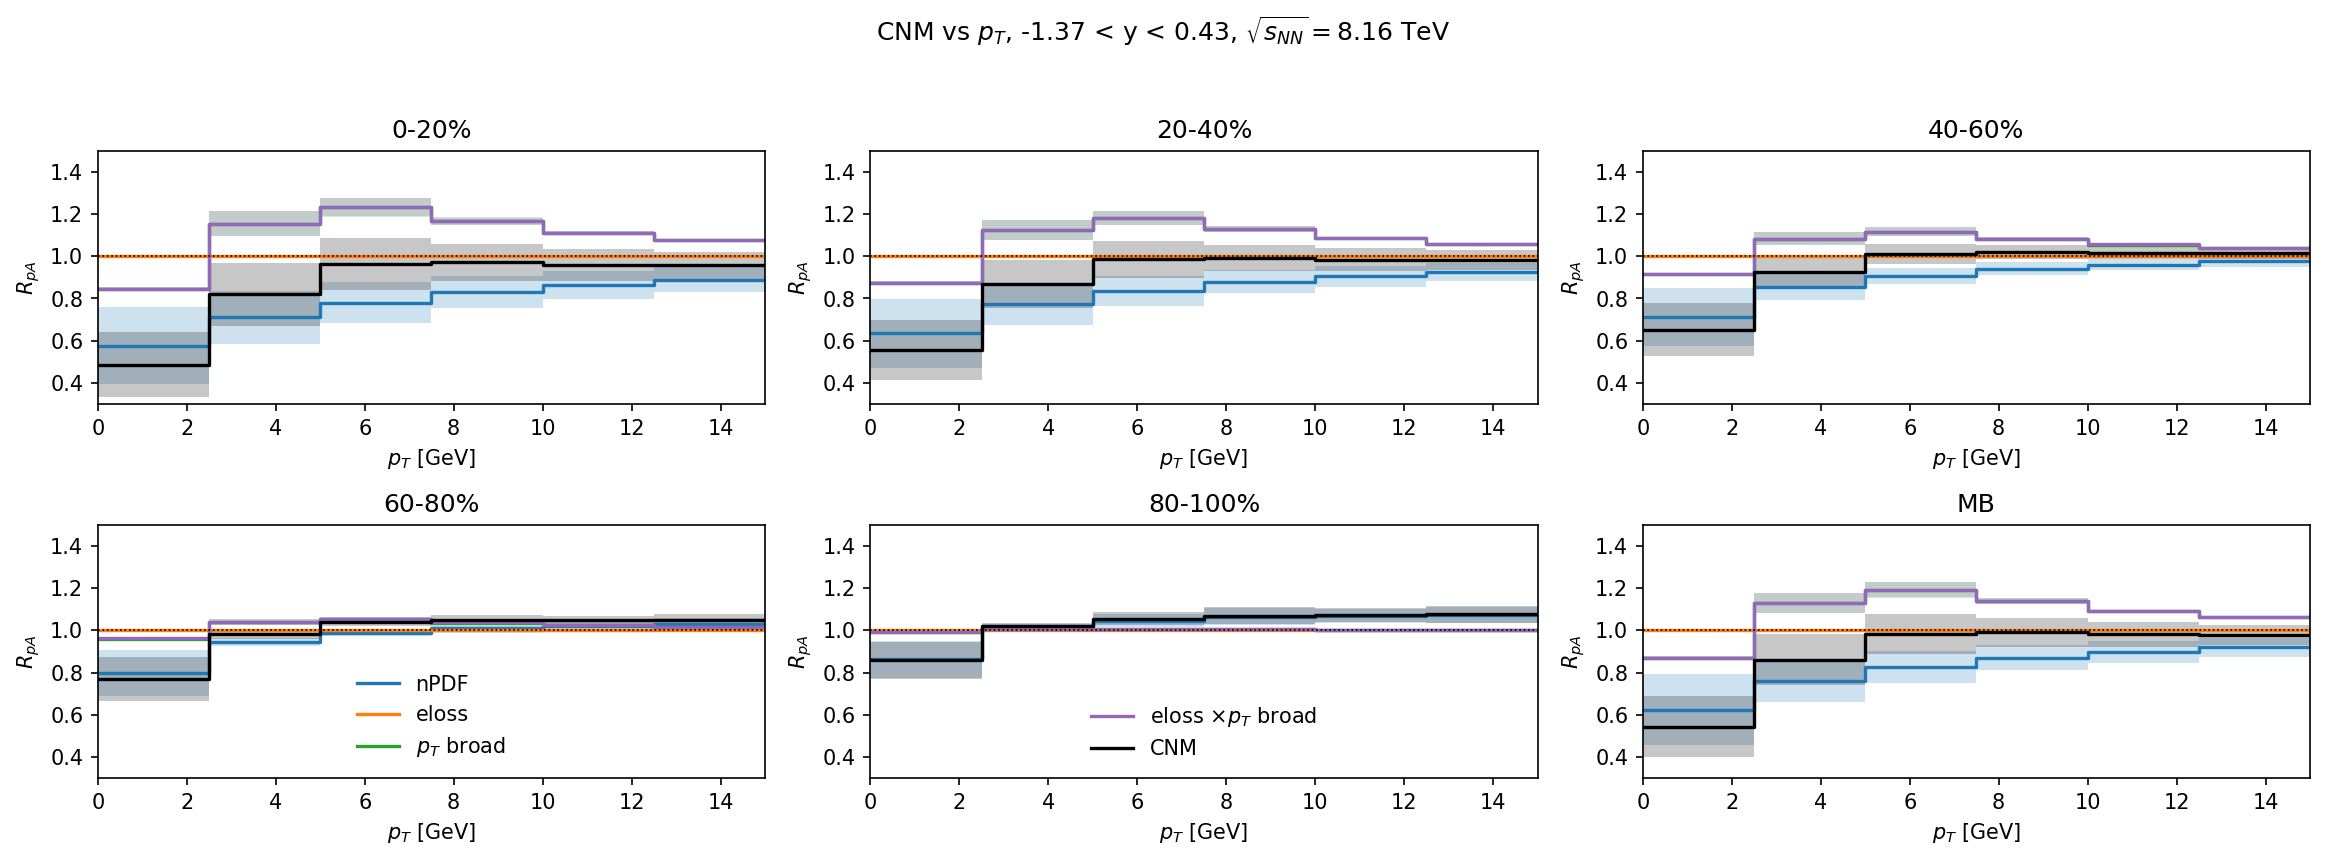

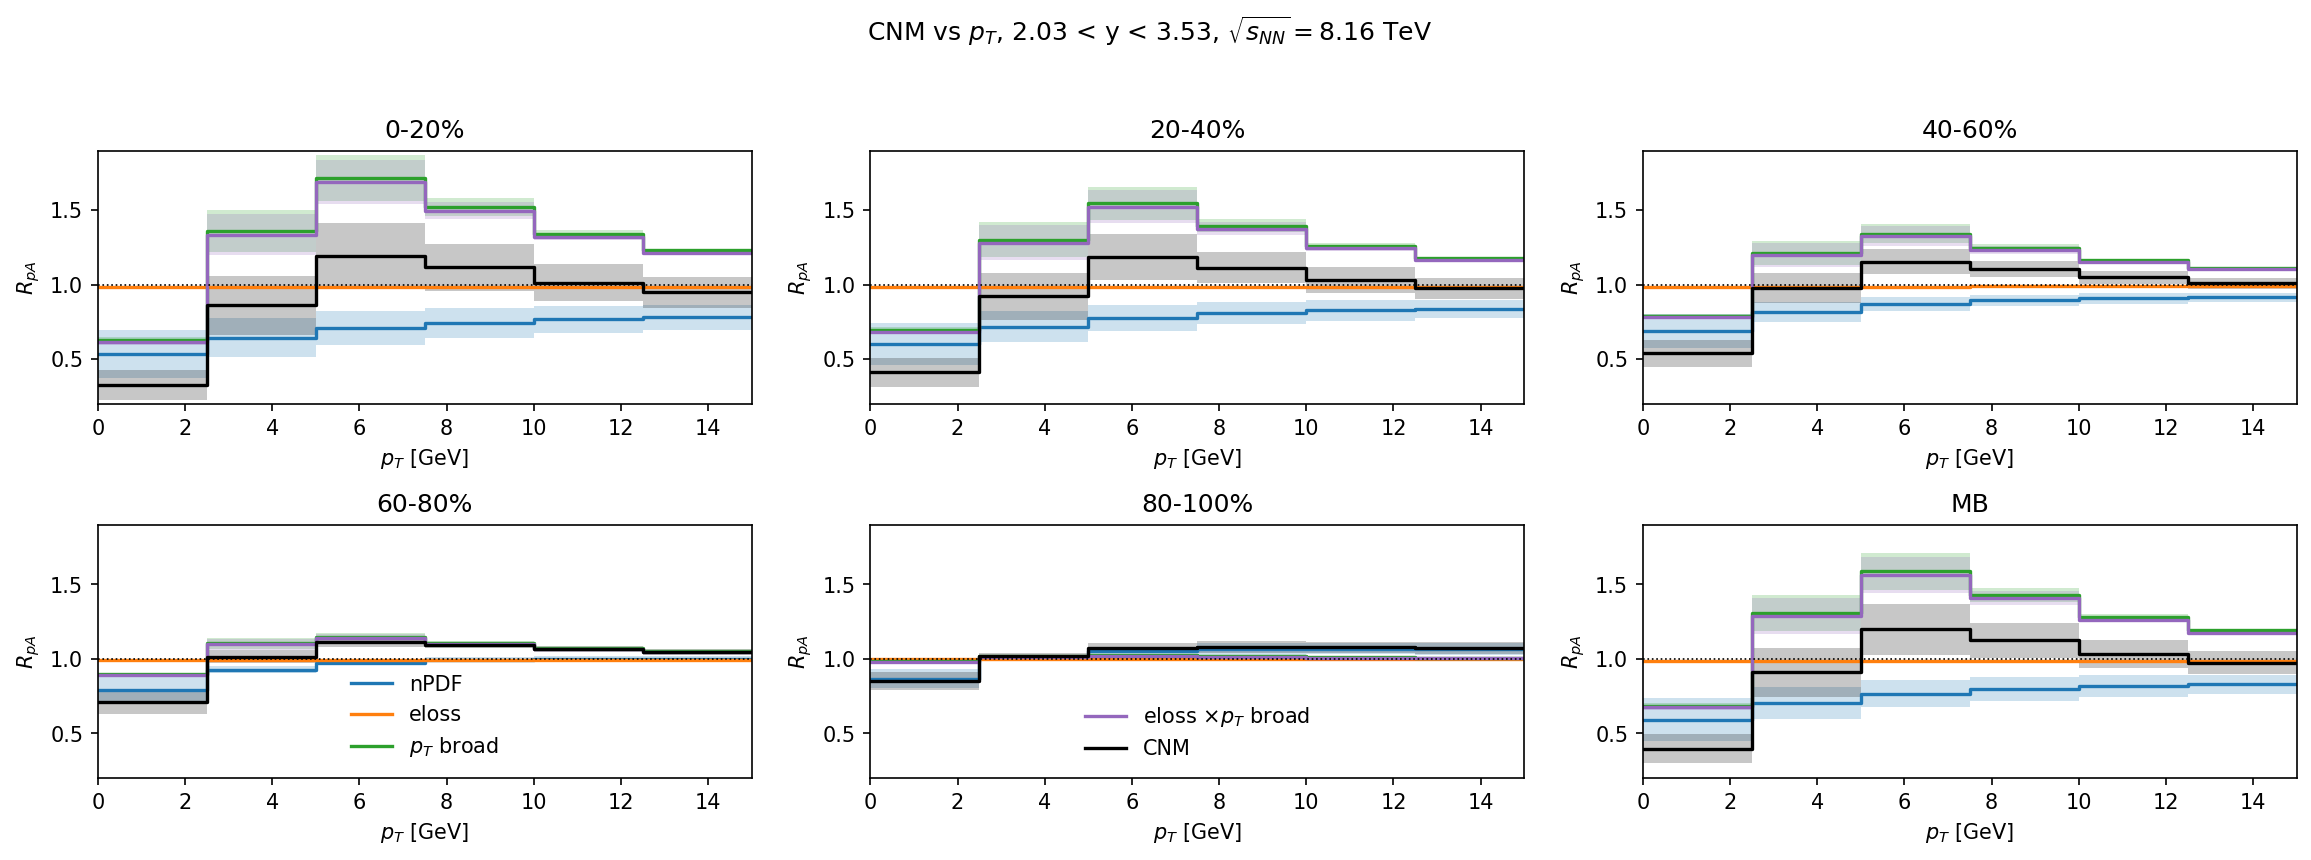

In [4]:
# ------------------------------------------------------------------
# 3. RpA vs pT : compute + save CSV + plot (3 y-windows)
# ------------------------------------------------------------------

YLIMS_PT = {
    DEFAULT_Y_WINDOWS[0][2]: (0.5, 1.50),
    DEFAULT_Y_WINDOWS[1][2]: (0.3, 1.50),
    DEFAULT_Y_WINDOWS[2][2]: (0.2, 1.90),
}

cnm_pt_all = {}  # cnm_pt_all[name][comp][tag] = (Rc,Rlo,Rhi)

for (y0, y1, name) in DEFAULT_Y_WINDOWS:
    pT_cent, tags_pt, cnm_pt = comb.cnm_vs_pT(
        y_window=(y0, y1, name),
        pt_edges=DEFAULT_P_EDGES,
        components=components,
        include_mb=True,
    )
    cnm_pt_all[name] = cnm_pt

    # Save CSVs
    if SAVE_CSV:
        for comp in components:
            df_pt = cnm_vs_pT_to_dataframe(
                pT_cent=pT_cent,
                tags=tags_pt,
                result=cnm_pt,
                component=comp,
            )
            safe_name = name.replace(" ", "").replace("<","").replace(">","").replace("y","y")
            df_pt.to_csv(
                OUTDIR / f"RpA_{comp}_vs_pT_{safe_name}_{ENERGY.replace('.','p')}TeV.csv",
                index=False,
            )

    # Plot for this y-window
    n_pan = len(tags_pt)
    n_cols = 3
    n_rows = int(np.ceil(n_pan / n_cols))

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(5.2 * n_cols, 2.9 * n_rows),
        dpi=DPI,
        sharex=False,
        sharey=False,
    )
    axes = np.atleast_1d(axes).ravel()

    handles_, labels_ = [], []
    ylim_pt = YLIMS_PT.get(name, (0.3, 1.5))

    for ip, tag in enumerate(tags_pt):
        ax = axes[ip]
        for comp in components:
            Rc, Rlo, Rhi = cnm_pt[comp][tag]

            col = COMP_COLORS[comp]
            lab = COMP_LABELS[comp] if ip == 0 else None

            x_edges, y_c  = step_from_centers(pT_cent, Rc)
            _,       y_lo = step_from_centers(pT_cent, Rlo)
            _,       y_hi = step_from_centers(pT_cent, Rhi)

            ln, = ax.step(
                x_edges, y_c,
                where="post",
                color=col, ls="-", lw=1.6,
                label=lab,
            )
            ax.fill_between(
                x_edges, y_lo, y_hi,
                step="post",
                color=col, alpha=ALPHA_BAND, linewidth=0.0,
            )

            if lab is not None:
                handles_.append(ln)
                labels_.append(lab)

        ax.axhline(1.0, color="k", ls=":", lw=0.8)
        ax.set_xlabel(r"$p_T$ [GeV]")
        ax.set_ylabel(r"$R_{pA}$")
        ax.set_xlim(DEFAULT_P_EDGES[0], DEFAULT_P_EDGES[-1])
        ax.set_ylim(*ylim_pt)
        ax.set_title(f"{tag}")

    # kill unused axes
    for k in range(n_pan, len(axes)):
        fig.delaxes(axes[k])

    # legends
    uniq = {}
    for h, l in zip(handles_, labels_):
        uniq[l] = h
    legend_handles = list(uniq.values())
    legend_labels  = list(uniq.keys())
    if legend_handles:
        mid = (len(legend_handles) + 1) // 2
        handles_1 = legend_handles[:mid]
        labels_1  = legend_labels[:mid]
        handles_2 = legend_handles[mid:]
        labels_2  = legend_labels[mid:]

        if n_pan > 3:
            axes[3].legend(
                handles_1, labels_1,
                loc="lower center", frameon=False, fontsize=10,
            )
        if n_pan > 4 and handles_2:
            axes[4].legend(
                handles_2, labels_2,
                loc="lower center", frameon=False, fontsize=10,
            )

    fig.suptitle(
        rf"CNM vs $p_T$, {name}, $\sqrt{{s_{{NN}}}}={comb.sqrt_sNN/1000:.2f}$ TeV"
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    if SAVE_PDF:
        safe_name = name.replace(" ", "_")
        fig.savefig(
            OUTDIR / f"RpA_CNM_vs_pT_{safe_name}_{ENERGY.replace('.','p')}TeV.pdf",
            bbox_inches="tight",
        )
    plt.show()